In [1]:
# Version 1.0 of tutorial: V.A. Moss, based on tutorial from M.A. Brentjens 08/08/2017
# This imports necessarily pylab functions from numpy and matplotlib
# Second commands make the fonts nicer 
%pylab notebook
import os
import sys
import time
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['serif'],'size':12})
start1 = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Convert subband number to central frequency
def sb_from_freq(freq,clock=200e6):
    chan = 0.5*clock/512.
    sb = round(freq/chan)
    return int(sb)

# Convert central frequency to subband number
def freq_from_sb(sb,clock=200e6):
    chan = 0.5*clock/512.
    freq = (sb*chan)
    return freq

In [3]:
# Initialisation parameters
cubename = '20170720_095816_xst.dat'
station = 'DE603LBA'
fname = cubename.split('_')[0]+'_'+station
stype = 'intl'
im_x,im_y = 101,101
subband = 297
freq = freq_from_sb(subband)

# Which slice in time to visualise
timestep = 5

# For ground imaging
dims = [-250,250,-250,250] # metres
height = 1.5 # metres

In [4]:
# Define a function to do the imaging
def sky_imager(visibilities,baselines,freq,im_x,im_y):
    img = np.zeros([im_y,im_x])
    for l_ix,l in enumerate(linspace(1,-1,im_y)):
        for m_ix,m in enumerate(linspace(-1,1,im_x)):
            n = sqrt(1-l**2-m**2)
            img[m_ix,l_ix] = np.mean(visibilities*exp(-2j*pi*freq*(baselines[:,:,0]*l + baselines[:,:,1]*m)/299792458.0))
    return img

# Define a function to do the imaging
def ground_imager(visibilities,baselines,freq,im_x,im_y,dims,station_pqr,height=1.5):
    img = np.zeros([im_y,im_x])
    for p_ix,p in enumerate(linspace(dims[0],dims[1],im_x)):
        for q_ix,q in enumerate(linspace(dims[2],dims[3],im_y)):
            r = height
            pqr = array([p,q,r])
            antdist = np.linalg.norm(station_pqr - pqr[newaxis,:],axis=1)
            groundbase = np.zeros([96,96])
            for i in range(0,96):
                groundbase[i] = antdist[i] - antdist[:]
            # Note: this is RFI integration second - normal second, to take out interference
            img[q_ix,p_ix] = np.mean(visibilities*exp(-2j*pi*freq*(-groundbase)/299792458.0))
    return img

In [33]:
# Function from Michiel: # of RCUs per station 
def rcus_in_station(station_type):
   r'''
   Returns the number of RCUs in a station, given its type.

   **Parameters**

   station_type : string
       The kind of station that produced the correlation. Choose one
       of 'core', 'remote', 'intl'.

   **Examples**

   >>> rcus_in_station('core')
   96
   >>> rcus_in_station('remote')
   96
   >>> rcus_in_station('intl')
   192
   >>> rcus_in_station('burp')
   Traceback (most recent call last):
   ...
   KeyError: u'burp'

   '''
   return {'core': 96, 'remote': 96, 'intl': 192}[station_type]


In [34]:
# Function from Michiel to read in an ACM binary data cube
def read_acm_cube(filename, station_type):
   r'''
   **Parameters**

   filename : string
       The file containing the array correlation matrix.

   station_type : string
       The kind of station that produced the correlation. Choose one
       of 'core', 'remote', 'intl'.

   **Returns**

   A 3D cube of complex numbers, where the indices are [time slots, rcu, rcu].

   **Examples**

   >>> cube = read_acm_cube('20170720_095816_xst.dat', 'intl')
   >>> cube.shape
   (29, 192, 192)
   '''
   num_rcu    = rcus_in_station(station_type)
   data       = fromfile(filename, dtype = complex128)
   time_slots = int(len(data)/num_rcu/num_rcu)
   return data.reshape((time_slots, num_rcu, num_rcu))

In [36]:
# Run all documentation tests in the functions above
import doctest
doctest.testmod()

TestResults(failed=0, attempted=6)

In [7]:
# Read cube
cube = read_acm_cube(cubename,stype)

In [8]:
# Print shape of cube
cube.shape

(29, 192, 192)

In [9]:
# Split into the XX and YY polarisations (RCUs)
cube_xx = cube[:,0::2,0::2]
cube_yy = cube[:,1::2,1::2]
visibilities = cube_xx[timestep,:,:]

In [10]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape

((29, 96, 96), (29, 96, 96))

<IPython.core.display.Javascript object>


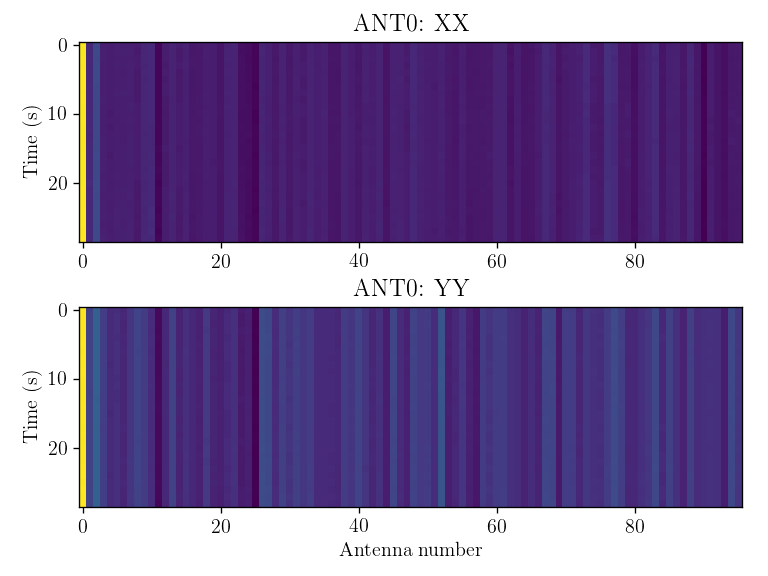

In [11]:
# Check how the various antennas/polarisation look with time
fig1, axes1 = subplots(nrows=2, ncols=1)
ax = axes1[0]
ax.imshow(cube_xx[:,0,:].real)
ax.set_ylabel('Time (s)')
ax.set_title('ANT0: XX')
ax = axes1[1]
ax.imshow(cube_yy[:,0,:].real)
ax.set_title('ANT0: YY')
ax.set_xlabel('Antenna number')
ax.set_ylabel('Time (s)')
tight_layout()

<IPython.core.display.Javascript object>


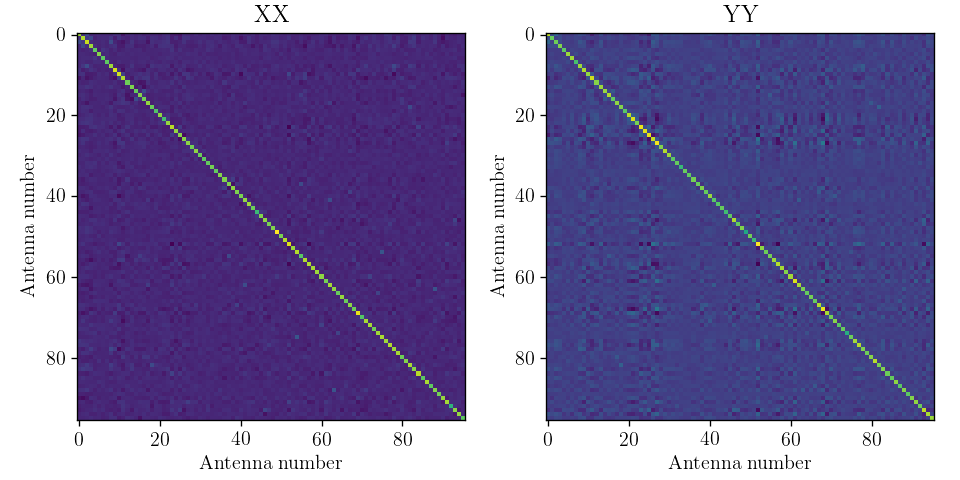

In [12]:
# Check how the correlations look with time
fig1, axes1 = subplots(nrows=1,ncols=2,figsize=(8,4))
ax = axes1[0]
ax.imshow(cube_xx[0,:,:].real)
ax.set_xlabel('Antenna number')
ax.set_ylabel('Antenna number')
ax.set_title('XX')
ax = axes1[1]
ax.imshow(cube_yy[0,:,:].real)
ax.set_title('YY')
ax.set_xlabel('Antenna number')
ax.set_ylabel('Antenna number')
tight_layout()

In [13]:
# Import Michiel's LOFAR antenna database
from lofarantpos.db import LofarAntennaDatabase

In [14]:
# Setup the database
db = LofarAntennaDatabase()

In [15]:
# Get the PQR positions for an individual station
station_pqr = db.antenna_pqr(station)

<IPython.core.display.Javascript object>


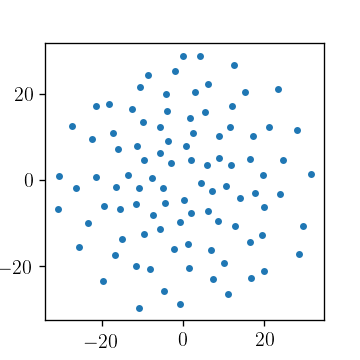

In [16]:
# Plot these positions (see layout of LBA)
figure(figsize=(3,3))
scatter(station_pqr[:,0],station_pqr[:,1],s=10)

In [17]:
# Check the shape of the PQR cube
station_pqr.shape

(96, 3)

In [18]:
# Establish an array to store the baseline offset positions
baselines = np.zeros([96,96,3])
baselines.shape

(96, 96, 3)

In [19]:
# For every antenna, calculate the "distance" between it and every other antenna
# THE SANDER METHOD!
start2 = time.time()
for i in range(0,96):
    baselines[i] = station_pqr[i]-station_pqr[:]
end2 = time.time()
print 'Time elapsed: %.3f ms' % ((end2-start2)*1000)

Time elapsed: 0.604 ms


In [20]:
# Check the shape of the baselines array
baselines.shape

(96, 96, 3)

<IPython.core.display.Javascript object>


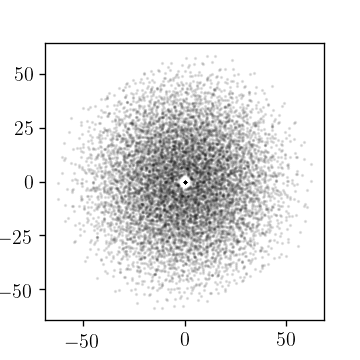

In [21]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
figure(figsize=(3,3))
plot(baselines[:,:,0],baselines[:,:,1],'k.',markersize=2,alpha=0.1)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


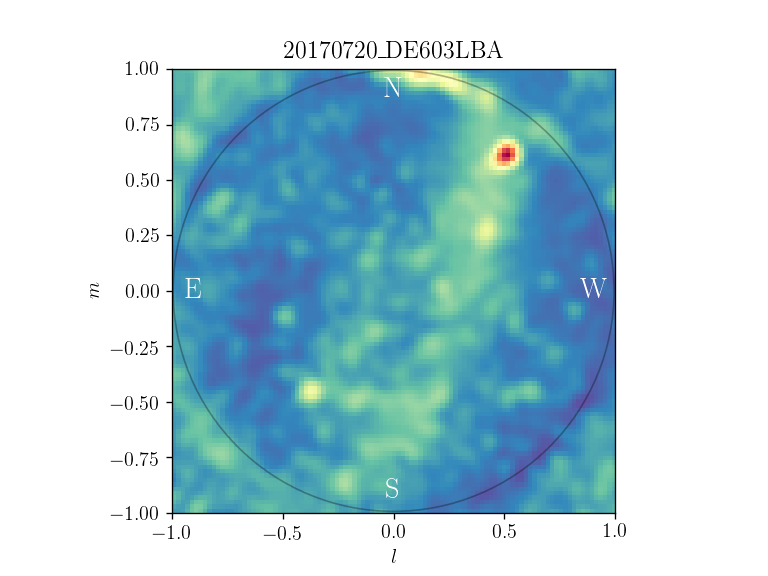

In [22]:
# Make a sky image, by numerically Fourier-transforming from visibilities to image plane
img = sky_imager(visibilities,baselines,freq,im_x,im_y)

# Plot the resulting image
figure()
imshow(img,origin='lower',cmap=cm.Spectral_r,extent=(-1,1,-1,1))
scatter(0,0,marker='o',facecolor='',edgecolor='k',s=7e4,linewidth=1,alpha=0.3)
xlabel('$l$')
ylabel('$m$')
title('\_'.join(fname.split('_')))

# Plot the compass directions
text(0.9,0,'W',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(-0.9,0,'E',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,0.9,'N',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,-0.9,'S',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


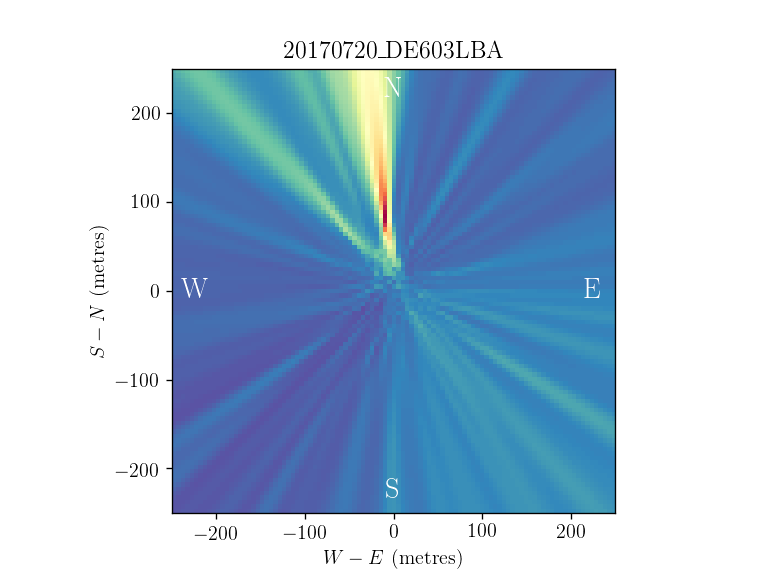

In [23]:
# Make a ground image, by numerically Fourier-transforming from visibilities to ground plane
img = ground_imager(visibilities,baselines,freq,im_x,im_y,dims,station_pqr)

# Plot the resulting image
figure()
imshow(img,origin='lower',cmap=cm.Spectral_r,extent=dims)
xlabel('$W-E$ (metres)')
ylabel('$S-N$ (metres)')
title('\_'.join(fname.split('_')))

text(225,0,'E',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(-225,0,'W',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,225,'N',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,-225,'S',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)

In [24]:
# Check total time to run
end1 = time.time()
print 'Time elapsed: %.2f s' % (end1-start1)

Time elapsed: 61.78 s
